# Objective:
To determine whether the the review is negative or positive

In [1]:
#importing the required packages
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') #connecting with the sql



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3 because 3 can be cosidered as a neutral
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.head(5)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
filtered_data.shape

(525814, 10)

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#deduplication
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
#removing the data which is not usefull
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
print(final.shape)
type(final)

(364171, 10)


pandas.core.frame.DataFrame

## TEXT PREPROCESSING

In [9]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'o', 'will', "hadn't", 'you', 'that', "mustn't", 'then', 'her', 'with', 'out', 'few', 'from', 'as', "she's", 'against', 'the', "haven't", 'do', 'a', 'mightn', "don't", 'shouldn', 'further', "aren't", 'theirs', 'hadn', 'up', 'haven', 'myself', 'only', 'had', "that'll", 'such', 'yours', 'd', 'won', 'through', 'yourself', "wasn't", 'of', 'himself', 'down', 't', 'who', "isn't", "it's", 'themselves', 'where', 'any', 'ain', 'for', 'again', 'wasn', 'they', 'it', "needn't", 'on', 'which', 'how', 'doing', 's', 'yourselves', 'were', 'more', 'because', 'does', 'doesn', 'mustn', 'why', 'other', 'i', 'my', 'there', 'nor', 'now', 're', 'above', 'him', 'those', 'both', 'about', 'under', 'is', 'when', 'aren', 'we', 'being', 'itself', 'own', 'did', 'weren', 'them', 'are', 'his', 'shan', 'over', 'between', 'but', 'if', "you've", 'before', "you'll", 'she', 'll', 'its', 'not', 'couldn', "doesn't", 'hasn', 'am', 'be', 'so', 'herself', 'an', 'has', 'by', 'or', 'than', "shouldn't", 'have', 'too', 'needn', '

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [62]:
positive=final[final['Score']=='positive']
negative=final[final['Score']=='negative']

In [80]:
np=positive.sample(n=2500)
nn=negative.sample(n=2500)

In [81]:
new=pd.concat([np,nn])
new.shape
print(type(new))

<class 'pandas.core.frame.DataFrame'>


# 1.BAG OF WORDS

In [247]:
#BAG of WORDS
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(new['CleanedText'].values)#Standardizing the data and collecting the vocab

In [248]:
from sklearn import preprocessing
final_counts=preprocessing.scale(final_counts,with_mean=False)

C:\Users\DEEPU\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [249]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)#1. perpplexity value is 30 and no. of iteration is 1000
tsne_data = model.fit_transform(final_counts.toarray())# Because t-sne will not take sparse matrix we are converting it to dense matrix using '.todense()'

In [250]:
tsne_data.shape

(5000, 2)

In [251]:
import numpy as np
Score1=new['Score']
tsne_data = np.vstack((tsne_data.T, Score1)).T


In [252]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

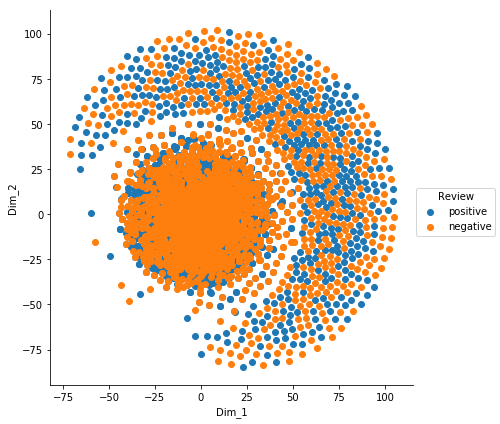

In [253]:
sns.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 1.(a)TSNE plot for perplexity value = 30 and number of iteration = 1000

In [254]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1500)#1. perplexity value is 40 and no. of iteration is 1500
tsne_data1 = model.fit_transform(final_counts.toarray())# Because t-sne will not take sparse matrix we are converting it to dense matrix using '.todense()'

In [255]:
import numpy as np
Score1=new['Score']
tsne_data1 = np.vstack((tsne_data1.T, Score1)).T

In [256]:
tsne_df1 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Review"))

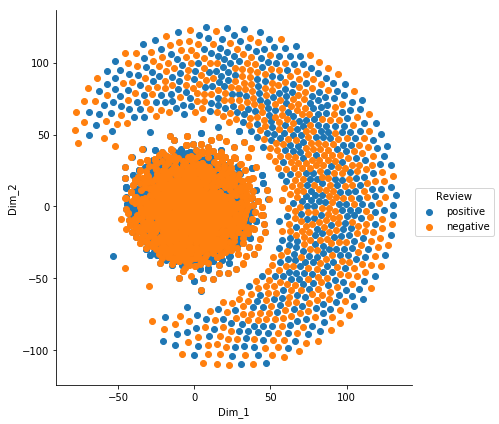

In [257]:
sns.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

##### 1.(b) The above graph is for BAG OF WORDS T-SNE Representation with perplexity value = 40 and iter = 1500

In [262]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=2500)#1. perplexity value is 50 and no. of iteration is 2500
tsne_data2 = model.fit_transform(final_counts.toarray())# Because t-sne will not take sparse matrix we are converting it to dense matrix using '.todense()'

In [263]:
import numpy as np
Score1=new['Score']
tsne_data2 = np.vstack((tsne_data1.T, Score1)).T

In [264]:
tsne_df2 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Review"))

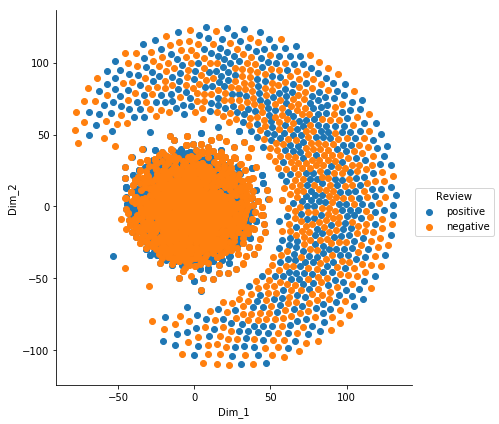

In [265]:
sns.FacetGrid(tsne_df2, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

##### 1.(c)The above graph is for BAG OF WORDS T-SNE Representation with perplexity value = 50 and iter = 2500

# 2. AVG. WORD2VEC

In [92]:
# Training Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [93]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [96]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [97]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.9059675335884094),
 ('yummy', 0.8548269271850586),
 ('satisfying', 0.8336074352264404),
 ('filling', 0.8332839608192444),
 ('delicious', 0.826215386390686),
 ('flavorful', 0.7942644357681274),
 ('tasteful', 0.7886030673980713),
 ('delectable', 0.7666944265365601),
 ('versatile', 0.7621180415153503),
 ('addicting', 0.7594195604324341)]

In [98]:
w2v_model.wv.most_similar('like')

[('resemble', 0.7102280855178833),
 ('mean', 0.6593261957168579),
 ('prefer', 0.6555219888687134),
 ('dislike', 0.6508166193962097),
 ('think', 0.6184096932411194),
 ('overpower', 0.5934004187583923),
 ('enjoy', 0.5918879508972168),
 ('fake', 0.5838400721549988),
 ('love', 0.5763999819755554),
 ('overwhelm', 0.5758147239685059)]

In [99]:
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in new['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\Users\DEEPU\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


5000
50


In [100]:
new_df=pd.DataFrame(sent_vectors)
new_df= new_df.fillna(new_df.median(axis=0))

In [109]:
from sklearn import preprocessing
new_df=preprocessing.scale(new_df,with_mean=False)#Standardizing the data before feed into TSNE

In [110]:
model = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=1000)# Setting perplexity value as 30 and number of iterations as 1000
tsne_data = model.fit_transform(new_df)

In [111]:
tsne_data.shape

(5000, 2)

In [112]:
Score1=new['Score']
tsne_data = np.vstack((tsne_data.T, Score1)).T

In [113]:
tsne_df1 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

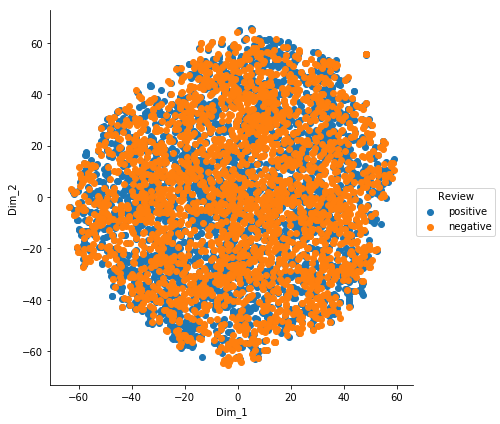

In [114]:
sns.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 2.(a)The above is a T-SNE plot of WORD2VEC with perplexity value 30 and number of iterations is 1000

In [268]:
model = TSNE(n_components=2, random_state=0,perplexity=40, n_iter=1500)# Setting perplexity value as 40 and number of iterations as 1500
tsne_data1 = model.fit_transform(new_df)

In [269]:
Score1=new['Score']
tsne_data1 = np.vstack((tsne_data1.T, Score1)).T

In [270]:
tsne_df2 = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "Review"))

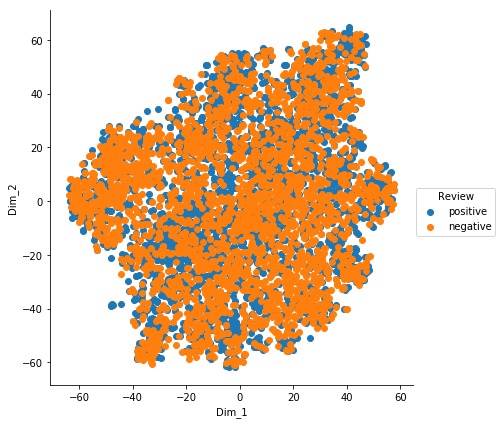

In [271]:
sns.FacetGrid(tsne_df2, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 2.(b)TSNE plot for perp=40 and n_iter = 1500

In [272]:
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=2500)# Setting perplexity value as 50 and number of iterations as 2500
tsne_data2 = model.fit_transform(new_df)

In [273]:
Score1=new['Score']
tsne_data2 = np.vstack((tsne_data2.T, Score1)).T

In [274]:
tsne_df3 = pd.DataFrame(data=tsne_data2, columns=("Dim_1", "Dim_2", "Review"))

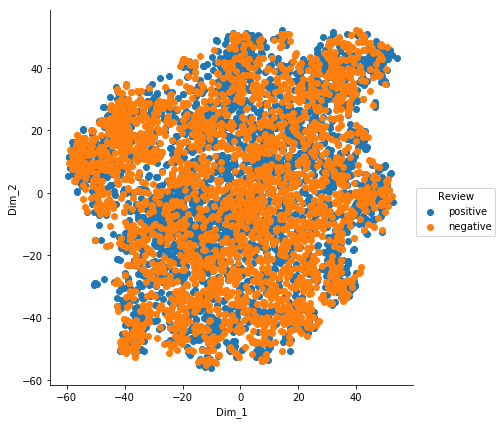

In [276]:
sns.FacetGrid(tsne_df3, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 2.(c)TSNE plot for perp=50 and n_iter = 2500

# 3.TF-IDF

In [153]:
tf_idf_vect = TfidfVectorizer()# It will create unigram as well as bigram
final_tf_idf = tf_idf_vect.fit_transform(new['Text'].values)

In [154]:
final_tf_idf.shape

(5000, 15144)

In [155]:
from sklearn import preprocessing
final_tf_idf1=preprocessing.scale(final_tf_idf,with_mean=False)#Standardizing the data before feed into TSNE

In [156]:
model = TSNE(n_components=2, random_state=0,perplexity=30,n_iter=1000)
tf_idf_data = model.fit_transform(final_tf_idf1.todense())

In [157]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data.T, Score1)).T

In [158]:
tsne_data.shape

(5000, 3)

In [159]:
tsne_df1 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

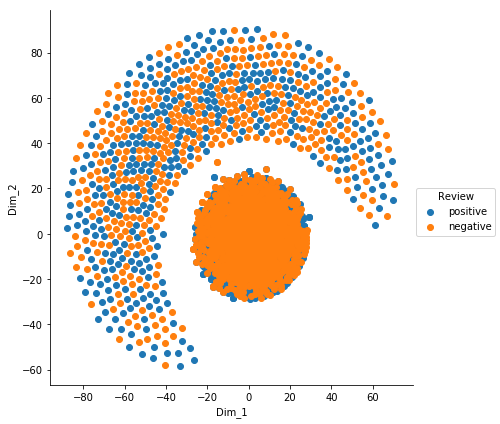

In [160]:
import seaborn as sn
sn.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 3.(a)Plot for TF-IDF with perp = 30 and n_iter= 1000

In [277]:
model = TSNE(n_components=2, random_state=0,perplexity=40,n_iter=1500)
tf_idf_data1 = model.fit_transform(final_tf_idf1.todense())

In [278]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data1.T, Score1)).T

In [279]:
tsne_df1 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

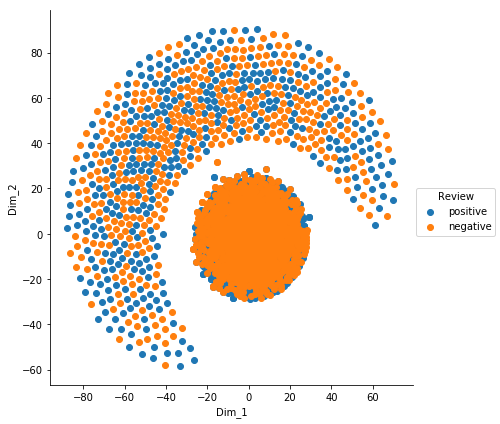

In [280]:
sn.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### 3. (b)Plot for TF-IDF with perp = 40 and n_iter= 1500

In [282]:
model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=2500)
tf_idf_data1 = model.fit_transform(final_tf_idf1.todense())

In [283]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data1.T, Score1)).T

In [284]:
tsne_df2 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

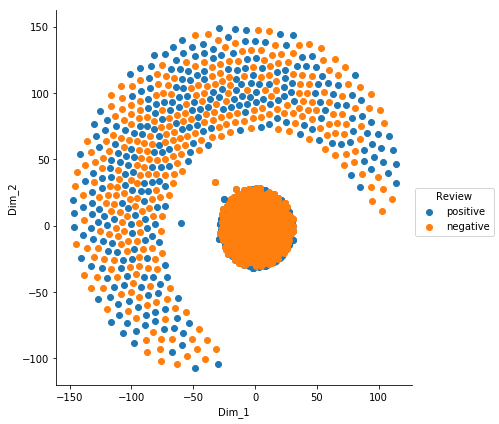

In [285]:
sn.FacetGrid(tsne_df2, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### TSNE plot with perp= 50 and n_iter =  2500

# 4.TF-IDF weighted Word2Vec

In [171]:
tf_idf_vect = TfidfVectorizer()# It will create unigram as well as bigram
final_tf_idf = tf_idf_vect.fit_transform(new['Text'].values)

In [194]:
import gensim
i=0
list_of_sent=[]
for sent in new['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [195]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [233]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in new['Text'].values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(' '): # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (tf_idf*vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

C:\Users\DEEPU\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [234]:
tfidf_sent_vectors[:5]

[array([ 0.50291058, -0.12999454,  0.92971165,  0.56497854, -0.64269973,
        -0.49282884, -0.15485148,  0.22422214, -0.04230404, -0.08787479,
        -0.06283135, -0.26984181,  0.14883939,  1.03133326,  0.32963131,
         0.27961925, -0.21961246,  0.32911863,  0.04337001, -0.18060499,
        -0.34967032,  0.06712608,  0.07179241, -0.25023729,  0.90690115,
        -0.16439249,  0.29022027,  0.00304868, -0.55472183,  0.0883675 ,
         0.51354313,  0.4115    , -0.61294713, -0.4435501 ,  0.06176675,
         0.31216449, -0.06015726, -0.42631134, -0.15369923,  0.26406163,
        -0.83185916,  0.64464903, -0.86904097, -0.11386573,  0.28782328,
         0.09396738, -0.52185968,  0.14275515, -0.49683559,  0.56136119]),
 array([ 0.45794443,  0.10869694,  0.80132822,  0.41668986, -0.62056841,
        -0.04110132, -0.14650213,  0.33980227, -0.49257847, -0.16950424,
        -0.25267751,  0.02474701, -0.21194334,  0.51120193,  0.07559661,
         0.59382154, -0.11460251,  0.36294061,  0

In [235]:
tfidf_w2v=pd.DataFrame(tfidf_sent_vectors)
tfidf_w2v= tfidf_w2v.fillna(tfidf_w2v.median(axis=0))

In [237]:
from sklearn import preprocessing
tfidf_w2v=preprocessing.scale(tfidf_w2v,with_mean=False)#Standardizing the data before feed into TSNE

In [239]:
model1 = TSNE(n_components=2, random_state=0,perplexity=30,n_iter = 1000)
tf_idf_data = model1.fit_transform(tfidf_w2v)

In [241]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data.T, Score1)).T

In [242]:
tsne_data.shape

(5000, 3)

In [244]:
tsne_df1 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

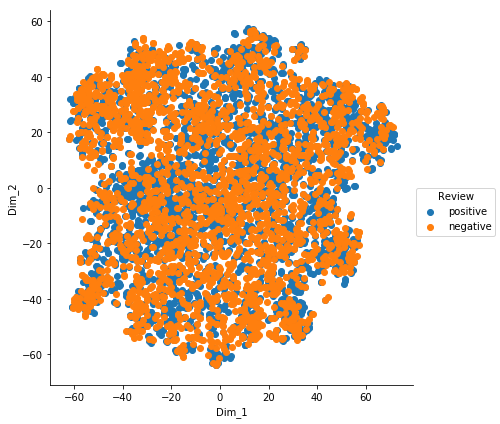

In [246]:
import seaborn as sn
sn.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### TF-IDF weighted word2vec with perp=30 and n_iter=1000

In [286]:
model2 = TSNE(n_components=2, random_state=0,perplexity=40,n_iter = 1500)
tf_idf_data1 = model2.fit_transform(tfidf_w2v)

In [287]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data1.T, Score1)).T

In [288]:
tsne_df1 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

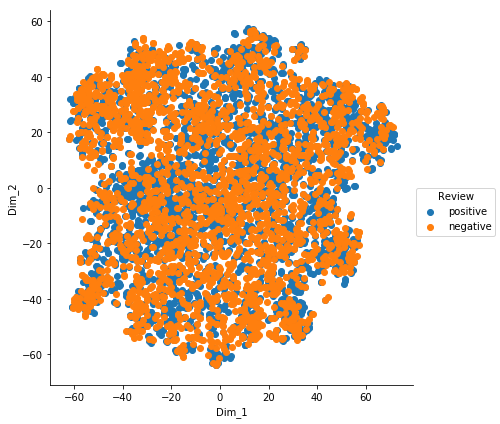

In [289]:
sn.FacetGrid(tsne_df1, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### TF-IDF weighted word2vec with perp=40 and n_iter=1500

In [291]:
model3 = TSNE(n_components=2, random_state=0,perplexity=50,n_iter = 2500)
tf_idf_data2 = model3.fit_transform(tfidf_w2v)

In [292]:
Score1=new['Score']
tsne_data = np.vstack((tf_idf_data2.T, Score1)).T

In [293]:
tsne_df2 = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

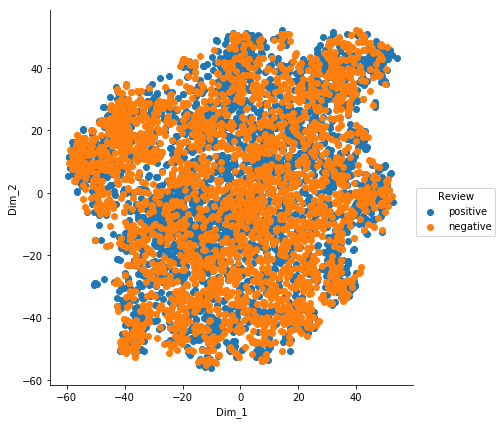

In [294]:
sn.FacetGrid(tsne_df2, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

#### TF-IDF weighted word2vec with perp=50 and n_iter=2500